## Introduction
In this tutorial, I would like to walk you through one of the most powerful and mostly used supervised learning methods -- random forest. I want to make sure after you finish this tutorial, you would at least get a taste of how to solve classification problem using random forest.

Tree based methods (like decision tree, random forest) empower predictive models with high accuracy, stability and ease of interpretation. Unlike linear models, they map non-linear relationships quite well.

[<img src="https://31.media.tumblr.com/79670eabe93cdd448c15f5bcb198d0fb/tumblr_inline_n8e398YbKv1s04rc3.png">](https://31.media.tumblr.com/79670eabe93cdd448c15f5bcb198d0fb/tumblr_inline_n8e398YbKv1s04rc3.png)

## Installing the libraries
Before getting started, you need to first install scikit-learn package on your computer. Scikit-learn is an open source Python library that implements a range of machine learning, preprocessing, cross-validation and visualization algorithms using a unified interface.

To check if scikit-learn is already installed on your computer, you can run:

    $ python -c "import sklearn"
    
If the terminal tells you "No module named sklearn", then you should install it manually:

    $ pip install -U scikit-learn
    
Note that scikit-learn has dependency on numpy and scipy, so you'd better install these two packages first.

In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import clone
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

## Decision Tree

In order to understand random forest, we need to know what is decision tree. Prof. Kolter has already talked about decision tree in class. Let us briefly review the concept.

The goal of decision tree is to predict the value of a target variable based on several input variables. Each interior node corresponds to one of the input variables; there are edges to children for each of the possible values of the input variable. Each leaf represents a value of the target variable given the values of the input variables represented by the path from the root to the leaf.

We can apply decision tree algorithm on Iris dataset as an example. The first thing is to load data and split it into training set and test set.

In [124]:
from sklearn.datasets import load_iris

def split_dataset(X, y):
    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Split data into training set and test set
    X_train = X[:training_size]
    y_train = y[:training_size]
    X_test = X[training_size:]
    y_test = y[training_size:]
    return X_train, X_test, y_train, y_test


# Constant
dataset_size = 150
training_size = 105
RANDOM_SEED = 13  
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

# Load the dataset
iris = load_iris()

# We only take the two corresponding features
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = split_dataset(X, y)

To get a better feel for the data, we can draw the scatter diagram. 

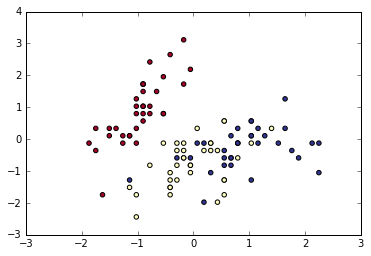

In [125]:
# Plot the training data points
fig = plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.show()

As we can tell from the above diagram, the data is labeled into three classes. Each class has almost the same amount of data. 

Then we run decision tree algorithm on the training data and plot the decision surface. 

0.952380952381


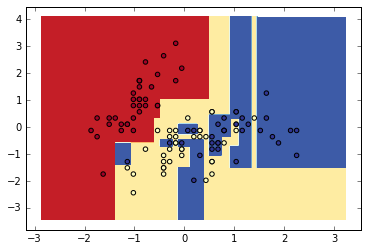

In [129]:
# Train
model = DecisionTreeClassifier(max_depth=None)
model = model.fit(X_train, y_train)

# Print the accuracy score
print model.score(X_train, y_train)

# Now plot the decision surface using a fine mesh as input to a
# filled contour plot
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# Plot the decision surface
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.show()

If we use training set to calculate the accuracy of the model, actually we can get a pretty good score (0.952). However, it is worth noticing that there are many blue blocks inside the yellow decision boundary which is usually a sign of overfitting. 

Then we continue to use test set to evaluate our model. The prediction accuracy turns out to be relatively low (0.578) which also confirms our previous analysis.

In [16]:
# Print the accuracy score
print model.score(X_test, y_test)

0.577777777778


While decision tree has many good features for example they are easy to interpret and allow non-linear parameters, it still has some notable disadvantages: 

1. It can be extremely sensitive to small perturbations in the data: a slight change can result in a drastically different tree.
2. It can easily overfit. This can be negated by validation methods and pruning, but this is a grey area.
3. It can have out-of-sample prediction problems (it cannot predit unseen data).

Then is there any method which maintains decision tree's advantages and avoids its' weak side in the meantime? The answer turns out to be **yes** and **random forest** is one of these methods.

## Random Forest
Let´s say you want to know if tomorrow will be sunny, rainy or cloudy based on several measurements from the previous day like temperature, dewpoint, cloud cover, humidity etc and you want to build a decision tree to forecast the weather. However the number of features is too larget (let's say 50), you don't know which measures to use.

The easiest way for you is to pick a **random** set of measurements and a **random** sample of your training set and build the tree by this part of data. Then you do the same many times using a different random set of measurements and a random sample of data each time. 

At the end you have many decision trees, you use each of them to forecast the weather and then decide the final forecast based on a simple majority.

Notice that because we choose measurements and sample data randomly, the model is robust to small fluctuation and overfit (Disadvange 1 & 2). And also we make predictions by likelihood which alleviate Disadvantage 3. 

In general, **Random Forest** is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

A key aspect of decision forests is the fact that its component trees are all randomly different from one another. This leads to de-correlation between the individual tree predictions and, in turn, to improved generalization. Forest randomness also helps achieve high robustness with respect to noisy data.

Let's implement a simple random forest classifier and apply it to test data.

In [55]:
from collections import Counter

# Constant
num_classifiers = 25
num_train_data = len(X_train)
num_test_data = len(X_test)

classifiers = []
for i in xrange(num_classifiers):
    # Randomly sample the training set
    index = np.random.choice(num_train_data, num_train_data)
    X_rf, y_rf = X_train[index], y_train[index]
    
    # Train
    model = DecisionTreeClassifier(max_depth=None)
    model = model.fit(X_rf, y_rf)
    classifiers.append(model)
    
y_predict = np.zeros(num_test_data)
for i in xrange(num_test_data):
    c = Counter([model.predict(X_test[i][None,:])[0] for model in classifiers])
    y_predict[i] = c.most_common()[0][0]

print "Accuracy score: "
print sum(y_predict == y_test) / float(num_test_data)

Accuracy score: 
0.688888888889


Looks like it is not a great improvement from 0.578 (decision tree) to 0.689 (random forest). However, if we apply two algorithms to all the features in Iris dataset, we can see a big difference (0.918 vs 0.961).

In [117]:
# Load the data from online database
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
dataframe = pd.read_csv(url)
array = dataframe.values
X_all = array[:,2:].astype('float')
y_all = np.array([1 if i == 'M' else 0 for i in array[:,1]])

X_all_train, X_all_test, y_all_train, y_all_test = split_dataset(X_all, y_all)

# Decision Tree model
model = DecisionTreeClassifier(max_depth=None)
model = model.fit(X_all_train, y_all_train)
print "Prediction accuracy of decision tree: "
print model.score(X_all_test, y_all_test)

# Random Forest model
model = RandomForestClassifier(n_estimators=30)
model = model.fit(X_all_train, y_all_train)
print "Prediction accuracy of random forest: "
print model.score(X_all_test, y_all_test)

Prediction accuracy of decision tree: 
0.917926565875
Prediction accuracy of random forest: 
0.961123110151


Similarly, we can draw the decision surfaces of random forest. However, this time the diagram will look a little bit different from last one. It is no longer divided into different blocks instead it is ploted by the probability of belonging to different classes. Because random forest uses majority voting among different decision trees to make predication.

It is also worth noticing that the transition between different classes becomes more smoothly

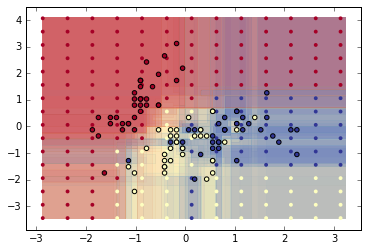

In [135]:
n_estimators = 30

# Train
model = RandomForestClassifier(n_estimators=n_estimators)
model = model.fit(X_train, y_train)

# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

estimator_alpha = 1.0 / len(model.estimators_)
for tree in model.estimators_:
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=plt.cm.RdYlBu)

# Build a coarser grid to plot the randomforest classifier
xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                     np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=plt.cm.RdYlBu, edgecolors="none")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.show()

## Comparison between Decision Tree and Random Forest


As a review we summarize the advantages and disadvantages of decision tree and random forest.
### Decision Tree
- Advantages
    1. Easy to Understand: The output of decision tree is easy to understand even for people from non-analytical background. It does not require any statistical knowledge to read and interpret them.
    2. Useful in Data exploration: Decision tree is one of the fastest way to identify most significant variables and relation between two or more variables.
    3. Less data preprocessing required: It requires less data cleaning compared to some other modeling techniques. It is not influenced by outliers and missing values to a fair degree.
    4. Data type is not a constraint: It can handle both numerical and categorical variables.
- Disadvantages
    1. Sensitive to fluctutation: It can be extremely sensitive to small perturbations in the data: a slight change can result in a drastically different tree.
    2. Over fitting: It can easily overfit. This can be negated by validation methods and pruning, but this is a grey area.

### Random Forest
- Advantages
    1. This algorithm can solve both regression and classification problem.
    2. It has the power to handle large dataset. And the process of building different decision trees can be parallelled.
    3. It is an effective method for estimating missing data and maintains accuracy.
    4. all advantages from decision tree
- Disadvantages:
    1. Random Forest can feel like a black box approach for statistical modelers – you have very little control on what the model does. You can at best – try different parameters and random seeds

## Application: Digit Classification
Here we will use Random Forest solve a classical classification problem. From this example, I'm sure you will have more confidence in what random forest can achieve. 

Recognizing handwritten digits originally showed up (as the legend goes) in the context of the United States Postal Service for the purpose of automatically sorting mail by the zip code of the destination. Given that the USPS processes 23 million pieces of mail per hour, it is impossible to sort these mails by manpower. So let's see how random forest fares in this realm.

First, each digit is represented as a 8x8 greyscale image. Now We are going to load the dataset and get a feel of what our dataset looks like. 

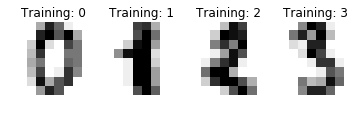

In [137]:
# Import datasets
from sklearn.datasets import load_digits

# The digits dataset
digits = load_digits()

# Plot the digit with its label
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)
plt.show()

Then we can use the same technology we discussed above: 
1. shuffle the data to make it distributed evenly
2. split the data into training set and test set
3. apply RandomForestClassifier on training set 
4. use test set to compute prediction accuracy

0.8268321513


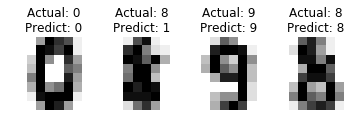

In [150]:
def split_data(X, y):
    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Split data into training set and test set
    X_train = X[:training_size]
    y_train = y[:training_size]
    X_test = X[training_size:]
    y_test = y[training_size:]
    return X_train, X_test, y_train, y_test

# Reshape the image, treat 8x8 grayscale values as 64 input features
image = digits.images
X = image.reshape(image.shape[0], image.shape[1] * image.shape[2])
y = digits.target

# Split the dataset into train set and test set
X_train, X_test, y_train, y_test = split_data(X, y)

# Use random forest model to train the data
rf_model = RandomForestClassifier(n_estimators=40, max_features=10)
rf_model = rf_model.fit(X_train, y_train)

# Calculate the prediction accuracy
print rf_model.score(X_test, y_test)

display_data = image[-4:]
X_display = display_data.reshape(display_data.shape[0], display_data.shape[1] * display_data.shape[2])
y_display = y[-4:]

predict = rf_model.predict(X_display)
# Plot the digit with its predicted value
images_and_labels = list(zip(display_data, y_display, predict))
for index, (image, label, predict) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Actual: %i\nPredict: %i' % (label, predict))

## References
There are many resources available on the Internet. Here I want to add some links which help me a lot with understanding random forest.

1. Awesome Random Forest: https://github.com/kjw0612/awesome-random-forest
2. Scikit-learn: http://scikit-learn.org/stable/
3. A Complete Tutorial on Tree Based Modeling from Scratch: https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/